In [61]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn import metrics
from sklearn.preprocessing import scale

In [62]:
data = pd.read_csv("./통신고객이탈.csv", engine="python")
data.head()

,CHURN,CUSTOMER_ID,GENDER,AGE,CHARGE_TYPE,HANDSET,USAGE_BAND,SERVICE_DURATION,DROPPED_CALLS,PEAK_CALLS_NO,PEAK_CALLS_TIME,WEEKEND_CALLS_NO,WEEKEND_CALLS_TIME,TOTAL_CALLS_NO,TOTAL_CALLS_TIME
0,Active,K102990,F,31,CAT 100,ASAD170,Med,33.33,6,218,379.8,9,21.6,366,632.4
1,Active,K103280,M,27,CAT 100,S50,Med,30.87,10,373,656.4,11,28.0,411,810.4
2,Active,K103660,M,27,CAT 100,ASAD170,Med,49.40,11,260,582.0,0,0.0,265,614.1
3,Active,K103730,M,61,CAT 100,ASAD170,Med,48.60,1,294,661.8,14,101.5,326,844.0
4,Active,K104560,F,52,CAT 100,S50,Med,56.03,0,221,555.6,7,25.0,274,673.0


In [63]:
data.isnull().sum()

CHURN                 0
CUSTOMER_ID           0
GENDER                0
AGE                   0
CHARGE_TYPE           0
HANDSET               0
USAGE_BAND            0
SERVICE_DURATION      0
DROPPED_CALLS         0
PEAK_CALLS_NO         0
PEAK_CALLS_TIME       0
WEEKEND_CALLS_NO      0
WEEKEND_CALLS_TIME    0
TOTAL_CALLS_NO        0
TOTAL_CALLS_TIME      0
dtype: int64

In [64]:
data.CHURN = data.CHURN.map(lambda x : 0 if x == 'Active' else 1)
# data.loc[data["CHURN"] == "Active","CHURN"] = 0
# data.loc[data["CHURN"] == "Churned","CHURN"] = 1
data.GENDER = data.GENDER.map(lambda x: 0 if x == 'F' else 1)
data.head()

,CHURN,CUSTOMER_ID,GENDER,AGE,CHARGE_TYPE,HANDSET,USAGE_BAND,SERVICE_DURATION,DROPPED_CALLS,PEAK_CALLS_NO,PEAK_CALLS_TIME,WEEKEND_CALLS_NO,WEEKEND_CALLS_TIME,TOTAL_CALLS_NO,TOTAL_CALLS_TIME
0,0,K102990,0,31,CAT 100,ASAD170,Med,33.33,6,218,379.8,9,21.6,366,632.4
1,0,K103280,1,27,CAT 100,S50,Med,30.87,10,373,656.4,11,28.0,411,810.4
2,0,K103660,1,27,CAT 100,ASAD170,Med,49.40,11,260,582.0,0,0.0,265,614.1
3,0,K103730,1,61,CAT 100,ASAD170,Med,48.60,1,294,661.8,14,101.5,326,844.0
4,0,K104560,0,52,CAT 100,S50,Med,56.03,0,221,555.6,7,25.0,274,673.0


In [65]:
np.random.seed(seed=1234)
msk = np.random.rand(data.shape[0],) < 0.7
df_train = data[msk]
df_test = data[~msk]

print("train_data_size:",df_train.shape)
print("test_data_size:",df_test.shape)

train_data_size: (635, 15)
test_data_size: (295, 15)


In [66]:
log_model = sm.Logit.from_formula("""CHURN ~ GENDER + AGE + C(CHARGE_TYPE) + C(HANDSET) + C(USAGE_BAND) +
                                    SERVICE_DURATION + DROPPED_CALLS + PEAK_CALLS_NO+PEAK_CALLS_TIME + 
                                    WEEKEND_CALLS_NO + WEEKEND_CALLS_TIME + TOTAL_CALLS_NO + TOTAL_CALLS_TIME + 1""",
                                 df_train)
# log_model = sm.Logit.from_formula("CHURN ~ AGE + 1",
#                                   df_const_train.drop("CUSTOMER_ID",axis=1))
log_res = log_model.fit(method="bfgs")
print(log_res.summary())

         Current function value: 0.261293
         Iterations: 35
         Function evaluations: 49
         Gradient evaluations: 42
                           Logit Regression Results                           
Dep. Variable:                  CHURN   No. Observations:                  635
Model:                          Logit   Df Residuals:                      605
Method:                           MLE   Df Model:                           29
Date:                Mon, 11 Feb 2019   Pseudo R-squ.:                  0.4660
Time:                        20:07:57   Log-Likelihood:                -165.92
converged:                      False   LL-Null:                       -310.70
                                        LLR p-value:                 9.369e-45
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -1.1342      2

/home/pirl/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1724: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/pirl/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1724: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/pirl/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [68]:
y_pred = log_res.predict(df_test)
y_pred_class = (y_pred >0.5).astype(int)
y_pred_class.head()

3    0
4    0
7    0
8    0
9    0
dtype: int64

In [69]:
print("Accuracy:{0:.3f}".format(metrics.accuracy_score(df_test["CHURN"],y_pred_class)))

Accuracy:0.898


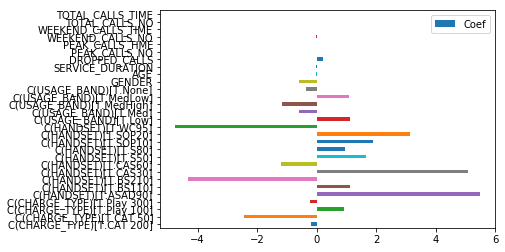

In [70]:
df_logistic_coef = pd.DataFrame({"Coef":log_res.params.values[1:]}, index=log_model.exog_names[1:])
df_logistic_coef.plot.barh(y="Coef")

In [71]:
df_char = data.select_dtypes(include="object")
df_numeric = data.select_dtypes(exclude="object")

df_char_train = df_char[msk]
df_numeric_scaled_train = scale(df_numeric[msk])
df_numeric_scaled_train = pd.DataFrame(df_numeric_scaled_train, columns=df_numeric.columns)
df_numeric_scaled_train.head()

/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  """


,CHURN,GENDER,AGE,SERVICE_DURATION,DROPPED_CALLS,PEAK_CALLS_NO,PEAK_CALLS_TIME,WEEKEND_CALLS_NO,WEEKEND_CALLS_TIME,TOTAL_CALLS_NO,TOTAL_CALLS_TIME
0,-0.487665,-0.958347,-0.061287,-0.066658,0.936779,-0.050954,-0.622843,-0.431938,-0.777862,0.069711,-0.778293
1,-0.487665,1.043463,-0.366521,-0.240702,2.073082,0.618542,-0.088273,-0.309382,-0.601091,0.247156,-0.454921
2,-0.487665,1.043463,-0.366521,1.070294,2.357157,0.130457,-0.232062,-0.983441,-1.374462,-0.328554,-0.811538
3,-0.487665,1.043463,1.464884,1.072417,0.084552,0.255718,-0.416436,-0.922163,-0.496134,0.310247,-0.286151
4,-0.487665,-0.958347,-0.137596,-0.139530,0.936779,0.851786,0.053197,-0.248104,0.083895,0.558670,-0.279066


In [72]:
df_numeric_scaled_train["CHURN"] = np.where(df_numeric_scaled_train["CHURN"]>0,1,0)
df_numeric_scaled_train.head()

df_scaled_train = pd.concat([df_numeric_scaled_train, df_char_train.reset_index(drop=True)],axis=1)

         Current function value: 0.262088
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/home/pirl/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


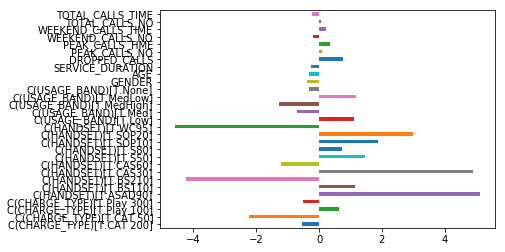

In [73]:
scaled_log_model = sm.Logit.from_formula("""CHURN ~ GENDER + AGE + C(CHARGE_TYPE) + C(HANDSET) + C(USAGE_BAND) +
                                    SERVICE_DURATION + DROPPED_CALLS + PEAK_CALLS_NO+PEAK_CALLS_TIME + 
                                    WEEKEND_CALLS_NO + WEEKEND_CALLS_TIME + TOTAL_CALLS_NO + TOTAL_CALLS_TIME + 1""",df_scaled_train)
scaled_log_res = scaled_log_model.fit(method="bfgs")
df_log_scaled_coef = pd.DataFrame({"Coef":scaled_log_res.params.values[1:]}, index=scaled_log_model.exog_names[1:])
df_log_scaled_coef.plot.barh(y="Coef",legend=False)

---